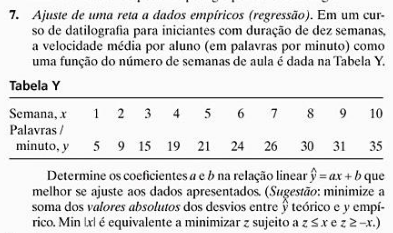

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Regressao_Desvio_Absoluto')

In [3]:
# --- Parâmetros extraídos do enunciado e da Tabela Y ---

# Dados empíricos (x: Semana, y: Palavras/minuto)
dados_empiricos = {
    1: 5,
    2: 9,
    3: 15,
    4: 19,
    5: 21,
    6: 24,
    7: 26,
    8: 30,
    9: 31,
    10: 35
}
pontos_x = dados_empiricos.keys()

In [4]:
# 1. Variáveis de Decisão

# Coeficientes da reta y = ax + b. Como podem ser negativos,
# cada um é representado pela diferença de duas variáveis não-negativas.
a_plus = model.continuous_var(name='a_plus', lb=0)
a_minus = model.continuous_var(name='a_minus', lb=0)
b_plus = model.continuous_var(name='b_plus', lb=0)
b_minus = model.continuous_var(name='b_minus', lb=0)

# Variáveis para os desvios positivos (d_plus) e negativos (d_minus) para cada ponto de dado.
d_plus = model.continuous_var_dict(pontos_x, name='d_p', lb=0)
d_minus = model.continuous_var_dict(pontos_x, name='d_m', lb=0)

# Expressões auxiliares para os coeficientes a e b
a = a_plus - a_minus
b = b_plus - b_minus


# 2. Função Objetivo
# Minimizar a soma dos desvios absolutos.
# O desvio absoluto para cada ponto i, |y_i - y_teorico_i|, é igual a d_plus[i] + d_minus[i].
expressao_soma_desvios = (d_plus[i] + d_minus[i] for i in pontos_x)
soma_desvios_absolutos = model.sum(expressao_soma_desvios)
model.minimize(soma_desvios_absolutos)


# 3. Restrições
# Para cada ponto, o valor real deve ser igual ao valor teórico mais o desvio.
# y_real = (a*x + b) + d_plus - d_minus
for x_i, y_i in dados_empiricos.items():
    valor_teorico = a * x_i + b
    restr_ajuste_logica = valor_teorico + d_plus[x_i] - d_minus[x_i] == y_i
    model.add_constraint(restr_ajuste_logica, ctname=f'ajuste_ponto_{x_i}')

In [5]:
# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    # Recupera os valores dos coeficientes
    a_sol = a_plus.solution_value - a_minus.solution_value
    b_sol = b_plus.solution_value - b_minus.solution_value
    soma_desvios = model.objective_value
    
    print(f"Soma Mínima dos Desvios Absolutos: {soma_desvios:,.4f}\n")
    
    print("--- Coeficientes da Reta ---")
    print(f"  - Coeficiente 'a': {a_sol:,.4f}")
    print(f"  - Coeficiente 'b': {b_sol:,.4f}")
    
    print(f"\nA equação da reta que melhor se ajusta aos dados é: ŷ = {a_sol:,.2f}x + {b_sol:,.2f}")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 2 columns.
Reduced LP has 10 rows, 22 columns, and 40 nonzeros.
Presolve time = 0.00 sec. (0.02 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000

------ SOLUÇÃO ÓTIMA ------

Soma Mínima dos Desvios Absolutos: 11.5714

--- Coeficientes da Reta ---
  - Coeficiente 'a': 2.8571
  - Coeficiente 'b': 6.4286

A equação da reta que melhor se ajusta aos dados é: ŷ = 2.86x + 6.43
